<a href="https://colab.research.google.com/github/Small-Fiend/CUDA_Laboratory/blob/main/Salt%20and%20Pepper/Salt_and_Pepper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import cv2
import time
import datetime

In [ ]:
def add_noise(img):
    print(img.shape)
    
    # Получаем размеров изображения
    row, col = img.shape
     
    # Случайным образом выбираем несколько пикселей на изображении для окрашивания их в белый цвет
    # Выбираем случайное число от 300 до 10000
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
       
        # Получаем случайную координату у
        y_coord=random.randint(0, row - 1)
         
        # Получаем случайную координату х
        x_coord=random.randint(0, col - 1)
         
        # Красим пиксель в белый цвет
        img[y_coord][x_coord] = 255
         
    # Аналогично действуем для раскрашивания пикселей в черный цвет
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
       
        
        y_coord=random.randint(0, row - 1)
        x_coord=random.randint(0, col - 1)
        img[y_coord][x_coord] = 0
         
    return img

Данный шум может применяться только к изображениям в градациях серого, поэтому необходимо его привести к данному виду при помощи функции cv2.IMREAD_GRAYSCALE

(466, 620)


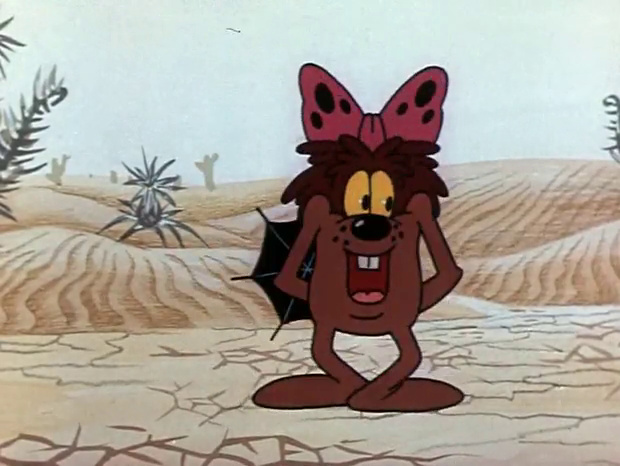

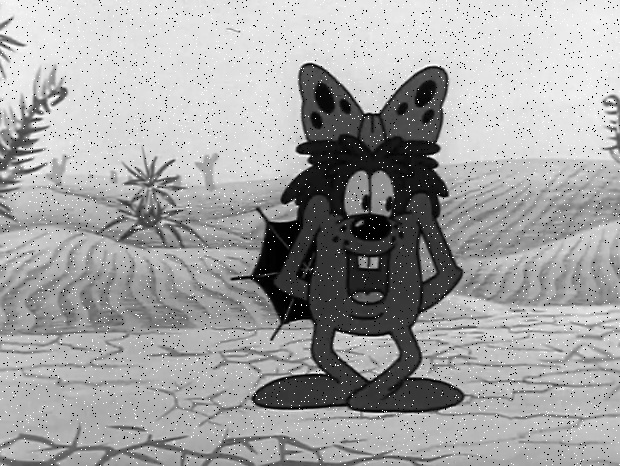

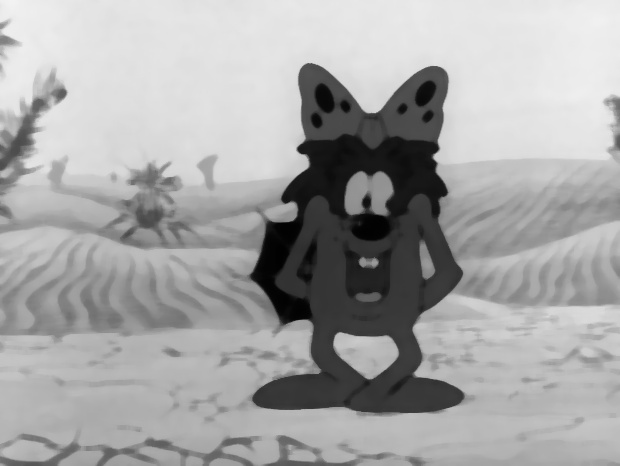

In [ ]:
img = '26934081.jpg'
i = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
cv2.imwrite('salt---and-pepper-26934081.jpg', add_noise(i))
img = cv2.imread('26934081.jpg')
cv2_imshow(img)
img_noise = cv2.imread('salt-and-pepper-26934081.jpg')
cv2_imshow(img_noise)
cv2.imwrite('median_26934081.jpg', cv2.medianBlur(img_noise, 9))
median_img = cv2.imread('median-26934081.jpg')
cv2_imshow(median_img)


Медианный фильтр на CPU

In [ ]:
cv2.imwrite('median_26934081.jpg', cv2.medianBlur(img_noise, 9))

True

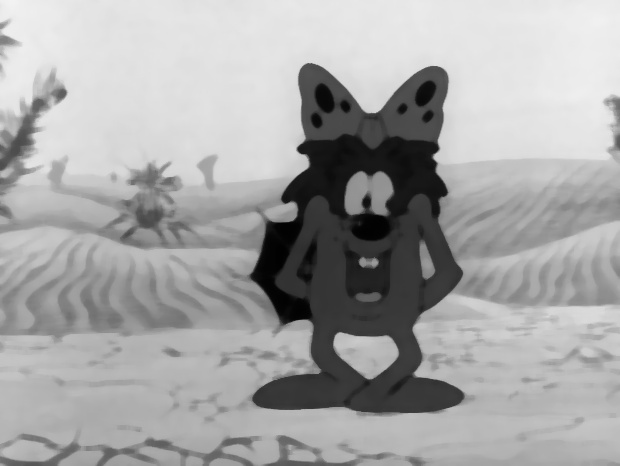

In [ ]:
cv2.imwrite('median_26934081.jpg', cv2.medianBlur(img_noise, 9))
median_img = cv2.imread('median_26934081.jpg')
cv2_imshow(median_img)

time on CPU:  0:00:00.043222


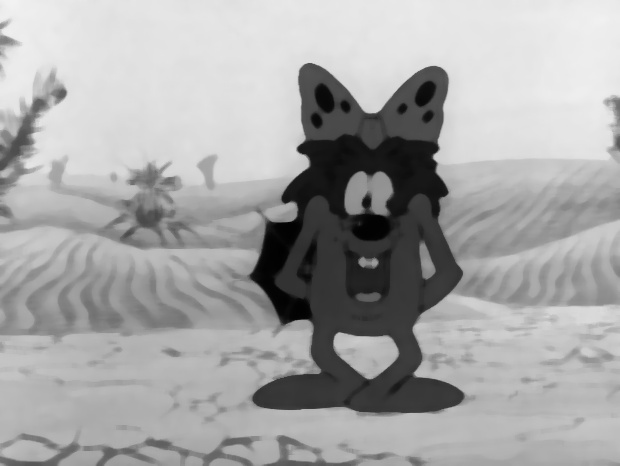

In [ ]:
start_time = datetime.datetime.now() 
median = cv2.medianBlur(img_noise, 9)
t1 = datetime.datetime.now() - start_time
print ('time on CPU:  '+ str(t1))
cv2.imwrite('median-CPU-26934081.jpg', median)
median_CPU_img = cv2.imread('median-CPU-26934081.jpg')
cv2_imshow(median_CPU_img)

Медианный фильтр на GPU

In [ ]:
#Устанавливаем pycuda
!pip install pycuda

     |████████████████████████████████| 1.7 MB 12.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 66 kB 4.7 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626633 sha256=52ff8c1f4dce020fc5bfaa27a5f35e2bd9087c8b6d6c3f2f4144d403a25d90ad
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=2e4dfb6fcaaf5963e19106ae7a6cddc8e7716dec762b351d12718035715d914c
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [ ]:
from pycuda import driver, compiler
import pycuda.autoinit
from pycuda.compiler import SourceModule
# Расчет будет производиться на блоках элементов TPBxTPB
TPB = 16

In [ ]:
import numba
from numba import cuda

In [ ]:
@cuda.jit
def median_GPU(imges, copy_img):
  i, j = cuda.grid(2)
  t = cuda.local.array(shape=9, dtype=numba.int64)
  t[0] = a[i-1][j-1]
  t[1] = a[i-1][j]
  t[2] = a[i-1][j+1]
  t[3] = a[i][j-1]
  t[4] = a[i][j]
  t[5] = a[i][j+1]
  t[6] = a[i+1][j-1]
  t[7] = a[i+1][j]
  t[8] = a[i+1][j+1]
  for k in range(8):
    for l in range(8-k):
      if t[l] > t[l+1]:
        t[l], t[l+1] = t[l+1], t[l]
  b[i][j] = t[(int)(len(t)/2)]

In [ ]:
def body_GPU(imаges):
  copy_img = imаges.copy()
  tread_number_block = 32

  d_img = cuda.to_device(imаges)
  d_copy = cuda.to_device(copy_img)    
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(imаges.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(copy_img.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time()
  median_GPU[blockspergrid, threadsperblock](d_img, d_copy)
  return d_copy.copy_to_host(), time()-start

In [ ]:
from PIL import Image
from io import BytesIO
from google.colab import files
import numpy as np

Saving 26934081.jpg to 26934081.jpg


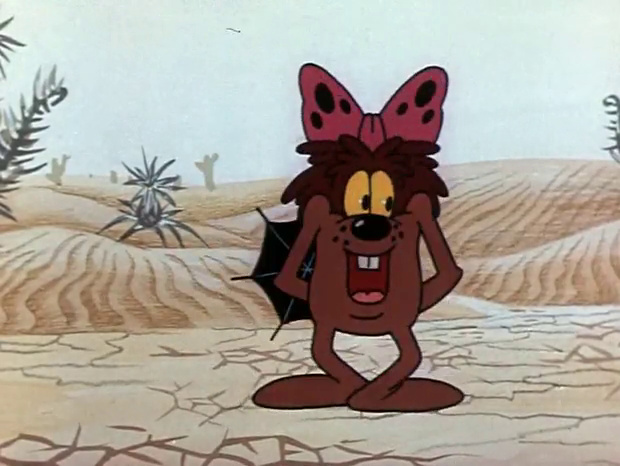

In [ ]:
uploaded = files.upload()
img = Image.open(BytesIO(uploaded['26934081.jpg']))
img

In [ ]:
def experiment(img_name, need_draw):
  im=(Image.open('26934081.jpg')).convert('L')
  if need_draw==True:
    display(im)
  img = np.array(im)

  img = add_noise(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img)))

  img2 = cv2.medianBlur(img, 9)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))

  img2, gtime = body_GPU(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))
  
  n=len(img)*len(img[0])
  print('количество пикселей:', n)
  print('cpu time', ctime)
  print('gpu time', gtime)
  print('ускорение', ctime/gtime)
  print()
  return ctime/gtime, n

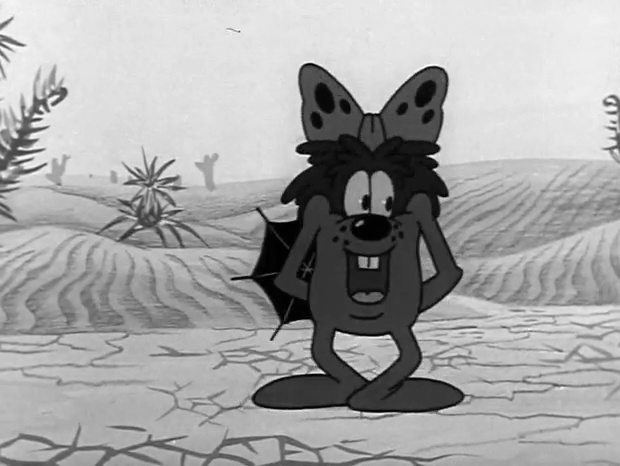

(466, 620)


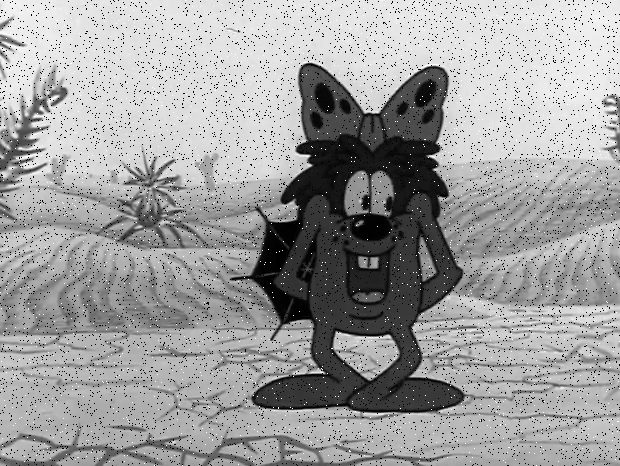

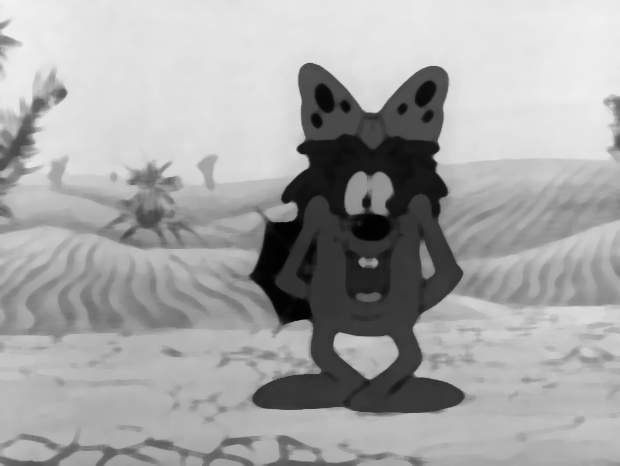

CudaSupportError: ignored

In [ ]:
a1, n1 = experiment('26934081.jpg', True)

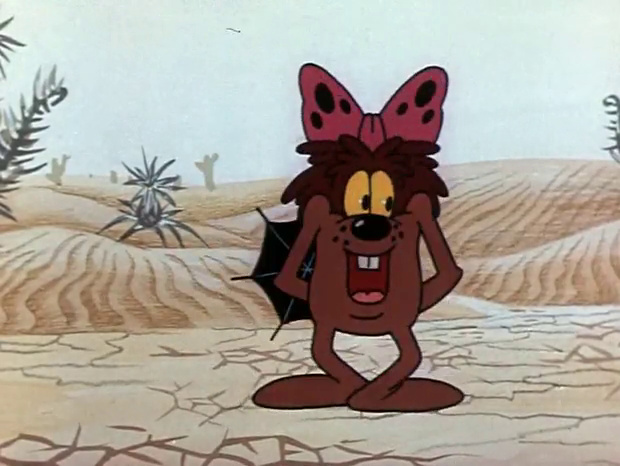

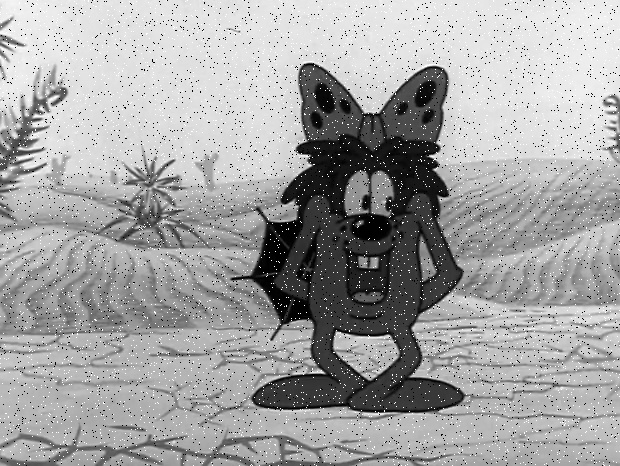

True

In [ ]:
img = cv2.imread('26934081.jpg')
cv2_imshow(img)
img_noise = cv2.imread('salt-and-pepper-26934081.jpg')
cv2_imshow(img_noise)
cv2.imwrite('salt.jpg', img_noise) 